# Optimization in Python using Vectorization - Application to Shallow Water Equations

### Dr. Matthew Smith, Swinburne University of Technology

The Shallow Water Equations are a set of coupled hyperbolic Partial Differential Equations (PDE) which govern the height-averaged motion of water. These equations are commonly used for simulation of Tsunamis and rainfall / flooding, and being hyperbolic, the solutions to these equations may potentially contain sudden jumps in the flow field called hydraulic jumps. These equations can be written as:


![title](SWE.svg)

Where $\rho$ is water density, which we will treat as constant in time and space, $\eta$ is water depth, $u$ and $v$ is the water velocity in x and y directions respectively and $g$ is gravitational acceleration. For the sake of simplicity, we can write these coupled PDEs into vector form:

\begin{align}
\frac{\partial U}{\partial t} + \frac{\partial F}{\partial x} + \frac{\partial G}{\partial y} = 0
\end{align}

where U is a vector of conserved quantities $U = [\eta, \eta u, \eta v]$. These are not convenient values to work with, hence we also introduce a vector of primitive values $P = [\eta, u, v]$ which holds the basic (hence primitive) values we have a more intuitive feel for.

## Basics - Numerical Solutions using the FVM

The Finite Volume Method (FVM) is one of the cornerstone methods for solving PDEs, and is one of the best options for solving hyperbolic PDEs. The key to the method is how space and time is broken down into finite intervals - hence, in the case of a horizontal "sheet" of water, we break the region down into a rectangular grid, like this:

![title](Grid.jpg)

This grid uses cartesian coordinate points to distinguish computational cells (volumes, or in this case, areas). The evolution of our conservative properties vector $U$ will be computed in time for each one of these cells using the Split HLL (SHLL) method, which involves computing split fluxes for each one of these cells using a vector computation - which makes it an ideal candidate for demonstrating the potential performance increase available to us through the use of vectorization in python. In the codes which follow, a rectangular domain of size (L, H) will be subdivided into $NX$, $NY$ cells (in the x and y directions), giving a total of $NX*NY$ cells in the simulation.


### Coding - Vectors in Python

Lets start with a piece of code which computes the values of P from the values of U in each one of these cells. There are two ways we could do this:

* By using a nested for loop (over NX and NY) - this is detailed in the function Compute_State_Slow() below.
* By using vectorization with numpy nd arrays - this is shown in the function Compute_State() below.

In [1]:
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

# ========== Function declarations ============

def Compute_State_Slow(P, U, NX, NY):
	# Compute primitives P from U using for loops.
	for x in range(NX):
		for y in range(NY):
			P[x,y,0] = U[x,y,0]		# Water Height
			P[x,y,1] = U[x,y,1]/U[x,y,0]	# X vel
			P[x,y,2] = U[x,y,2]/U[x,y,0]	# Y vel
	return P


def Compute_State(P, U):
        # Compute Primitives P from U using vectors
        P[:,:,0] = U[:,:,0]   		# Water Height
        P[:,:,1] = U[:,:,1]/U[:,:,0]	# X vel
        P[:,:,2] = U[:,:,2]/U[:,:,0]	# Y vel
        return P

The first thing to notice: these codes perform an identical function, as in the returned values of P are the same. P and U are both 3D numpy arrays of dimensions $[NX, NY, 3]$. It ought to be clear from previous classes in vectorization with python that the code $P[:,:,0] = U[:,:,0]$ will process all of the elements in the first two dimensions of the arrays (i.e. over all NX and NY elements), hence the reason no for loops are required. In this case, as the computation is identical for each element, the computation is a typical SIMD style calculation which is perfectly performed using vectorization. Now let's look at a harder demonstration.

In [2]:
def Compute_Change_of_State(dU, FP, FM, NX, NY, PHI, direction):
        # Compute the change of state based on gradients of F
        FL = np.ndarray([NX,NY,3])
        FR = np.ndarray([NX,NY,3])

        if (direction == 0):
                # This is the X direction computation
                for x in range(NX):
                        if (x == 0):
                                # Left boundary - use Neuman condition
                                FL[x,:,:] = FP[x,:,:]
                                FR[x,:,:] = FM[x+1,:,:]
                        elif (x == (NX-1)):
                                # Right boundary - use Neuman as well
                                FL[x,:,:] = FP[x-1,:,:]
                                FR[x,:,:] = FM[x,:,:]
                        else:
                             	# Internal cell. All is fine and dandy.
                                FL[x,:,:] = FP[x-1,:,:]
                                FR[x,:,:] = FM[x+1,:,:]

                # Now to apply them to update the state
                dU = dU - PHI*(FP - FM + FR - FL);

        elif (direction == 1):
                # This is for the Y direction
                for y in range(NY):
                        if (y == 0):
                                # Left boundary - use Neuman
                                FL[:,y,:] = FP[:,y,:]
                                FR[:,y,:] = FM[:,y+1,:]
                        elif (y == (NY-1)):
                                # Right boundary - use Neuman
                                FL[:,y,:] = FP[:,y-1,:]
                                FR[:,y,:] = FM[:,y,:]
                        else:
                             	# Internal cell.
                                FL[:,y,:] = FP[:,y-1,:]
                                FR[:,y,:] = FM[:,y+1,:]

                # Now to apply them to update the state
                dU = dU - PHI*(FP - FM + FR - FL);

        return dU

The function Compute_Change_of_State() calculates the change in conserved quantity $U$ based on the gradients of fluxes in the provided direction (0 for $x$, 1 for $y$). This is an example of vectorization applied to a less-than-ideal situation as, unlike last time, this calculation is not perfectly SIMD. This is because of boundary condition treatment - fluxes along the edges of our domain are treated differently than those for cells on the inside. However, since we are dealing with a rectangular region, we can still apply vectorization in 'strips' in our domain and across our coupled PDE set. A specific example - the code $FL[:,y,:] = FP[:,y-1,:]$ takes all NX values (1st dimension) and all 3 PDE equation fluxes from the strip y-1 (the strip below y). Finally, the code $dU = dU - PHI*(FP-FM+FL-FL)$ is a computation across all elements and equations of dimension (NX, NY, 3). We haven't needed to use 3 for loops to perform this computation, as we would if we (for example) had used C/C++ instead of Python.

This function represents the least computationally efficient part of this example, but we've done what we can. Now for another example of a well vectorized code - the split flux computation:

In [4]:
def Compute_Fluxes_Slow(P, NX, NY, G, D, direction):
	# Compute split SHLL fluxes in each direction using slow loops
        FP = np.ndarray([NX, NY, 3])
        FM = np.ndarray([NX, NY, 3])
        U = np.ndarray([NX, NY, 3])

        # Compute fluxes in particular direction as required
        F = np.ndarray([NX,NY,3])

        # Recompute a local copy of U based on P
	for x in range(NX):
		for y in range(NY):
		        U[x,y,0] = P[x,y,0]
        		U[x,y,1] = P[x,y,0]*P[x,y,1]
        		U[x,y,2] = P[x,y,0]*P[x,y,2]

        if (direction == 0):
                # X direction.
		for x in range(NX):
			for y in range(NY):
                		a = np.sqrt(P[x,y,0]*G)
				vel = P[x,y,1]  # X velocity
                		Fr = vel/a  # Froud number
                		# Compute some important constants
                		Z1 = 0.5*(D*Fr+1.0)
                		Z2 = 0.5*D*a*(1.0-Fr*Fr)
                		Z3 = 0.5*(D*Fr-1.0)

                		# Compute X direction fluxes
                		F[x,y,0] = U[x,y,1]   # Height * X velocity
                		F[x,y,1] = U[x,y,1]*P[x,y,1] + 0.5*G*P[x,y,0]*P[x,y,0]
                		F[x,y,2] = U[x,y,1]*P[x,y,2] # Height*Xvel*Yvel

		                # Compute the SHLL forward and backward fluxes
		                FP[x,y,0] = F[x,y,0]*Z1 + U[x,y,0]*Z2
                		FP[x,y,1] = F[x,y,1]*Z1 + U[x,y,1]*Z2
                		FP[x,y,2] = F[x,y,2]*Z1 + U[x,y,2]*Z2

                		FM[x,y,0] = -F[x,y,0]*Z3 - U[x,y,0]*Z2
                		FM[x,y,1] = -F[x,y,1]*Z3 - U[x,y,1]*Z2
                		FM[x,y,2] = -F[x,y,2]*Z3 - U[x,y,2]*Z2

        elif (direction == 1):
                # Y direction
		for x in range(NX):
			for y in range(NY):
				a = np.sqrt(P[x,y,0]*G)
                		vel = P[x,y,2]  # Y Velocity
                		Fr = vel/a
                		# Compute some important constants
                		Z1 = 0.5*(D*Fr+1.0)
                		Z2 = 0.5*D*a*(1.0-Fr*Fr)
                		Z3 = 0.5*(D*Fr-1.0)

                		# Compute Y direction fluxes
                		F[x,y,0] = U[x,y,2]   # Height * Y velocity
                		F[x,y,1] = U[x,y,2]*P[x,y,1] # Height*Yvel*Xvel
                		F[x,y,2] = U[x,y,2]*P[x,y,2] + 0.5*G*P[x,y,0]*P[x,y,0]

               			# Compute the SHLL forward and backward fluxes
                		FP[x,y,0] = F[x,y,0]*Z1 + U[x,y,0]*Z2
                		FP[x,y,1] = F[x,y,1]*Z1 + U[x,y,1]*Z2
                		FP[x,y,2] = F[x,y,2]*Z1 + U[x,y,2]*Z2

                		FM[x,y,0] = -F[x,y,0]*Z3 - U[x,y,0]*Z2
                		FM[x,y,1] = -F[x,y,1]*Z3 - U[x,y,1]*Z2
                		FM[x,y,2] = -F[x,y,2]*Z3 - U[x,y,2]*Z2


	return FP, FM


Without going into too many of the meaty details, here is the situation - to compute the net flux across a cell surface, we use critical number splitting to separate contributions based on location. The end result - we need to compute forward fluxes (FP) and backward fluxes (FM) in each cell (for all NX, NY cells) and for each equation (3 equations). In the code shown above - Compute_Fluxes_Slow(), this is done using two for loops over NX and NY for each direction. There is no reason for us to use for loops here - the computation in each cell is identical, and so we can use vectorization very effectively: let's have a look at the vectorized version:

In [5]:
def Compute_Fluxes(P, NX, NY, G, D, direction):
	# Compute split SHLL fluxes in each direction
        FP = np.ndarray([NX, NY, 3])
        FM = np.ndarray([NX, NY, 3])
        U = np.ndarray([NX, NY, 3])

        # Compute fluxes in particular direction as required
        F = np.ndarray([NX,NY,3])

        # Recompute a local copy of U based on P
        U[:,:,0] = P[:,:,0]
        U[:,:,1] = P[:,:,0]*P[:,:,1]
        U[:,:,2] = P[:,:,0]*P[:,:,2]

        # Use the direction to access the correct velocity information
        a = np.sqrt(P[:,:,0]*G)

        if (direction == 0):
                # X direction.
                # Attempt to vectorize the computation
                vel = P[:,:,1]  # X velocity
                Fr = vel/a  # Froud number
                # Compute some important constants
                Z1 = 0.5*(D*Fr+1.0)
                Z2 = 0.5*D*a*(1.0-Fr*Fr)
                Z3 = 0.5*(D*Fr-1.0)

                # Compute X direction fluxes
                F[:,:,0] = U[:,:,1]   # Height * X velocity
                F[:,:,1] = U[:,:,1]*P[:,:,1] + 0.5*G*P[:,:,0]*P[:,:,0]
                F[:,:,2] = U[:,:,1]*P[:,:,2] # Height*Xvel*Yvel

                # Compute the SHLL forward and backward fluxes
                FP[:,:,0] = F[:,:,0]*Z1 + U[:,:,0]*Z2
                FP[:,:,1] = F[:,:,1]*Z1 + U[:,:,1]*Z2
                FP[:,:,2] = F[:,:,2]*Z1 + U[:,:,2]*Z2

                FM[:,:,0] = -F[:,:,0]*Z3 - U[:,:,0]*Z2
                FM[:,:,1] = -F[:,:,1]*Z3 - U[:,:,1]*Z2
                FM[:,:,2] = -F[:,:,2]*Z3 - U[:,:,2]*Z2

        elif (direction == 1):
                # Y direction
                vel = P[:,:,2]  # Y Velocity
                Fr = vel/a
                # Compute some important constants
                Z1 = 0.5*(D*Fr+1.0)
                Z2 = 0.5*D*a*(1.0-Fr*Fr)
                Z3 = 0.5*(D*Fr-1.0)

                # Compute Y direction fluxes
                F[:,:,0] = U[:,:,2]   # Height * Y velocity
                F[:,:,1] = U[:,:,2]*P[:,:,1] # Height*Yvel*Xvel
                F[:,:,2] = U[:,:,2]*P[:,:,2] + 0.5*G*P[:,:,0]*P[:,:,0]

                # Compute the SHLL forward and backward fluxes
                FP[:,:,0] = F[:,:,0]*Z1 + U[:,:,0]*Z2
                FP[:,:,1] = F[:,:,1]*Z1 + U[:,:,1]*Z2
                FP[:,:,2] = F[:,:,2]*Z1 + U[:,:,2]*Z2

                FM[:,:,0] = -F[:,:,0]*Z3 - U[:,:,0]*Z2
                FM[:,:,1] = -F[:,:,1]*Z3 - U[:,:,1]*Z2
                FM[:,:,2] = -F[:,:,2]*Z3 - U[:,:,2]*Z2

        return FP, FM

We've basically removed all the for loops over NX, NY and replaced them with vectorized versions. Here, the Froude number (important in the studies of shallow water flows) is computed for all cells in the flow field (in the direction specified) using the code $Fr = vel/a$ - hence, $Fr$, $vel$ and $a$ are all two dimensional arrays (of size NX, NY), as are the constants $Z1, Z2$ and $Z3$. By creating these 2D array variables, we can compute our split fluxes quickly - in fact, this code could be vectorized even further by making these three dimensional (i.e. NX, NY, 3) at the expense of additional memory requirement - a common compromise which we often make in search of faster codes. I'll leave this as an exercise for the reader. 

Finally, we are almost ready to go - we need another function to graph our result (not really the focus of this notebook) but we also need to set the initial condition (water height and velocity) at the start of the simulation. We use the Init() function to do this:

In [6]:
def Plot_All_Surfaces(P, DX, DY, NX, NY):
        # Plot all results within a single figure
        L = NX*DX
        H = NY*DY
        X,Y = np.mgrid[0:L:DX, 0:H:DY]
        Z = P[:,:,0] # Height
        levels = MaxNLocator(nbins=25).tick_values(Z.min(), Z.max())
        cmap = plt.get_cmap('gist_rainbow')
        norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
        fig,ax = plt.subplots(1,3,figsize=(30, 10),subplot_kw=dict(projection='3d'))
        ax[0].plot_surface(X,Y,Z, cmap=cmap, norm=norm)
        ax[0].set_title('Height')
        ax[0].set_xlabel('X')
        ax[0].set_ylabel('Y')
        # X Velocity
        Z = P[:,:,1] # X Vel
        levels = MaxNLocator(nbins=25).tick_values(Z.min(), Z.max())
        cmap = plt.get_cmap('gist_rainbow')
        norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
        ax[1].plot_surface(X,Y,Z, cmap=cmap, norm=norm)
        ax[1].set_title('X Velocity')
        ax[1].set_xlabel('X')
        ax[1].set_ylabel('Y')
        # Y Velocity
        Z = P[:,:,2] # Y Vel
        levels = MaxNLocator(nbins=25).tick_values(Z.min(), Z.max())
        cmap = plt.get_cmap('gist_rainbow')
        norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
        ax[2].plot_surface(X,Y,Z, cmap=cmap, norm=norm)
        ax[2].set_title('Y Velocity')
        ax[2].set_xlabel('X')
        ax[2].set_ylabel('Y')
        plt.show()

        return 0


def Init(U, P, NX, NY):
        # Compute initial values of U and P
	for x in range(NX):
                for y in range(NY):
                        # Compute initial conditions based on location
                        if ((x < 0.6*NX) and (x > 0.4*NX) and (y < 0.6*NY) and (y > 0.4*NY)):
                                P[x,y,0] = 10.0   # Water height
                        else:
                             	P[x,y,0] = 1.0

                        # The water is initially stationary
                        P[x,y,1] = 0.0  # X speed
                        P[x,y,2] = 0.0  # Y speed

        # Now to compute U from P
        U[:,:,0] = P[:,:,0]  	# Water Height is conservative
        U[:,:,1] = P[:,:,0]*P[:,:,1] # Height*X Vel = X Mom
        U[:,:,2] = P[:,:,0]*P[:,:,2] # Y Mom
        return U, P

    

We can see the initial condition as set by Init() is to have an elevated (i.e. deeper) part of water surrounded by shallow water - we should see this produce waves which spread out as this water level drops and dissipates into the surrounding fluid. You can experiment with different initial conditions to see what patterns you can produce at your leisure. Now, let's run a simulation.

### Main Simulation Code

In [10]:
# Main Code section
# =================

# Solution Parameters
L = 1.0    # Length of region (x direction), m
H = 1.0    # Height of region (y direction), m
NX = 50	   # Number of cells in X direction
NY = 50    # Number of cells in Y direction
DX = (L/NX) # Grid size in X direction
DY = (H/NY) # "      "     Y direction
DT = 0.00005 # Time step, in seconds (s). Static for now.
NO_STEPS = 400 # Number of time steps to take
G = 9.81        # Gravitational accelerationm m/s2
D = 0.9		# Anti-dissipation coefficient
USE_FAST = True		# Decide which routines to use - fast (True) or not (False)

# Create our nd arrays
P = np.ndarray([NX, NY, 3])   # Primitives - height, water speed in x,y directions
U = np.ndarray([NX, NY, 3])   # Conservatives - height and momentum in x,y directions
FP = np.ndarray([NX, NY, 3])  # Forward (positive, P) fluxes of conserved quantities
FM = np.ndarray([NX, NY, 3])  # Backward (minus, M) fluxes
dU = np.ndarray([NX, NY, 3])  # Changes to conserved quantities

# Initialize the flow field
U,P = Init(U,P,NX,NY)


Here is where we set up our main simulation parameters before we start the time loop to solve the transient motion of water. The domain size (L,H), number of cells (NX, NY), grid size (DX, DY) and the number and size of time steps are all set here. Pay particular attention to the USE_FAST variable - if this is set to $True$, we will use the vectorized functions, which will result in a substantially increased performance. Once these are all set, and we have set up U and P (using the Init() function), we are ready to begin transient time stepping.

In [11]:
tic = time.time()
for step in range(NO_STEPS):
	print("Time step %d of %d" % (step, NO_STEPS))

	# Reset dU
	dU = 0*dU

	# Calculate fluxes in X direction (direction = 0)
	if (USE_FAST):
		# Employ vectorization to compute fluxes
		FP, FM = Compute_Fluxes(P, NX, NY, G, D, 0)
	else:
		# Compute fluxes slowly
		FP, FM = Compute_Fluxes_Slow(P, NX, NY, G, D, 0)
	# Update dU
	dU = Compute_Change_of_State(dU, FP, FM, NX, NY, (DT/DX), 0)

	# Update fluxes in Y direction (direction = 1)
	if (USE_FAST):
		# Employ vectorization to compute fluxes
		FP, FM = Compute_Fluxes(P, NX, NY, G, D, 1)
	else:
		# Compute the fluxes slowly
		FP, FM = Compute_Fluxes_Slow(P, NX, NY, G, D, 1)
	# Update dU
	dU = Compute_Change_of_State(dU, FP, FM, NX, NY, (DT/DY), 1)

	# Update dU
	U = U + dU

	# Update our state P
	if (USE_FAST):
		P = Compute_State(P, U)
	else:
		# Use the slow method
		P = Compute_State_Slow(P, U, NX, NY)

	# End of main transient time loop segment

# Simulation is completed now. Examine the results.
toc = time.time()
Elapsed_Time = toc - tic
print("Elapsed time = %g seconds" % Elapsed_Time)


Time step 0 of 400
Time step 1 of 400
Time step 2 of 400
Time step 3 of 400
Time step 4 of 400
Time step 5 of 400
Time step 6 of 400
Time step 7 of 400
Time step 8 of 400
Time step 9 of 400
Time step 10 of 400
Time step 11 of 400
Time step 12 of 400
Time step 13 of 400
Time step 14 of 400
Time step 15 of 400
Time step 16 of 400
Time step 17 of 400
Time step 18 of 400
Time step 19 of 400
Time step 20 of 400
Time step 21 of 400
Time step 22 of 400
Time step 23 of 400
Time step 24 of 400
Time step 25 of 400
Time step 26 of 400
Time step 27 of 400
Time step 28 of 400
Time step 29 of 400
Time step 30 of 400
Time step 31 of 400
Time step 32 of 400
Time step 33 of 400
Time step 34 of 400
Time step 35 of 400
Time step 36 of 400
Time step 37 of 400
Time step 38 of 400
Time step 39 of 400
Time step 40 of 400
Time step 41 of 400
Time step 42 of 400
Time step 43 of 400
Time step 44 of 400
Time step 45 of 400
Time step 46 of 400
Time step 47 of 400
Time step 48 of 400
Time step 49 of 400
Time step 

The time required to execute these time loops depends on your computer, your chosen values of NX, NY and the number of time steps. It's worth noting that we cannot increase the value of DT too much without risking instability - be careful here, though the code will run just fine with the original values provided. 

### Influence of Vectorization on Performance

By changing the value of USE_FAST from False to True, you ought to see a substantial improvement on the time required to complete the calculation (depending on your machine). On Swinburne's OzStar supercomputer, typical computational times are shown below:

* Using USE_FAST = False (i.e. slow functions): Time required = 17.2 seconds.
* Using USE_FAST = True (i.e. vector functions): Time required = 0.27 seconds.

This is an increase in performance of over 60 times! It's not unusual for these computations to require hours to complete (ask an expert in CFD), and so its clear that the effective use of vectorization is almost compulsory if youve chosen to use Python as the language for this application. The core reason behind this increase in performance is AVX vectorization - through the effective use of vectors, numpy is able to take advantage of the AVX SIMD registers within your ALU (i.e. math core of your CPU) which permit in-core vectorization using vector intrinsics. There are other factors involved in the performance increase as well.

### Viewing the flow field

Finally, let's see what fruits our efforts have produced by graphing the final result:

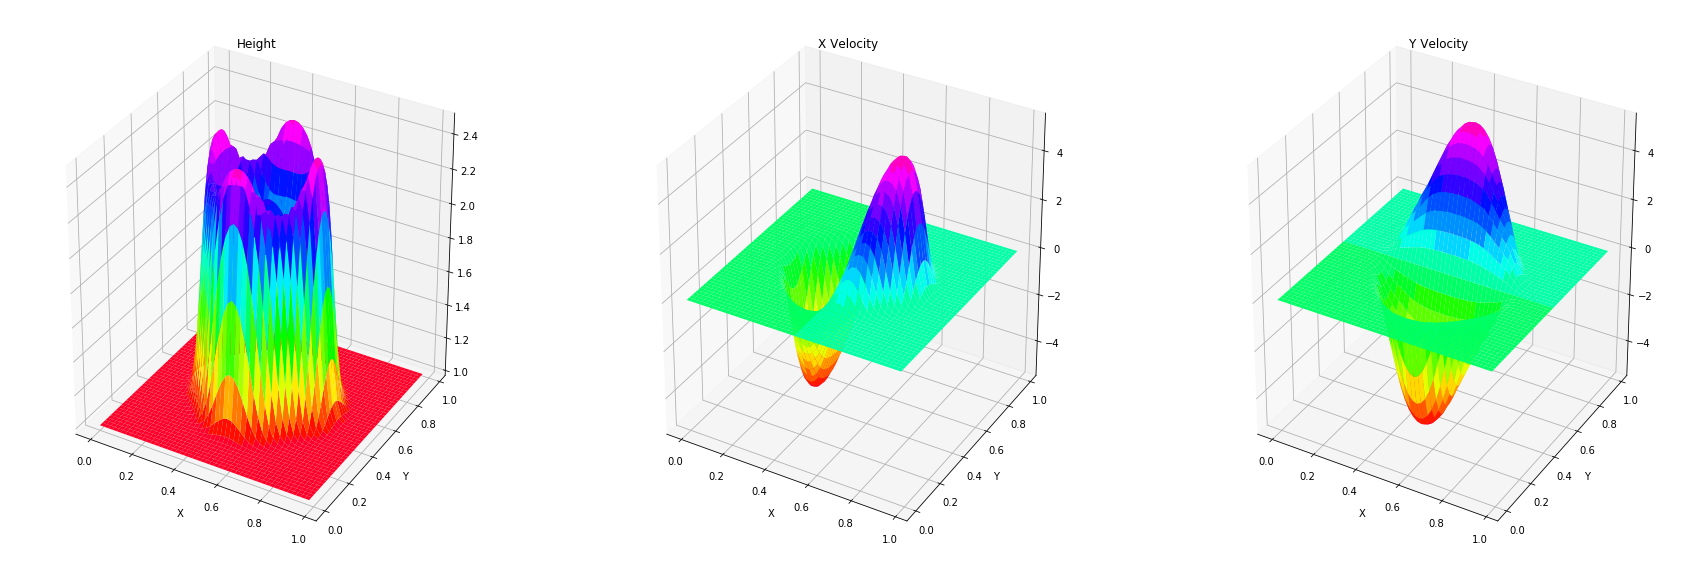

0

In [9]:
# Plot FP
Plot_All_Surfaces(P,DX,DY,NX,NY)

If your simulation has worked as intended, then you ought to see the (initially elevated) water column collapse, producing waves in the X-Y plane which are best seen in the X and Y velocity plots. Feel free to experiment with initial conditions - a commonly used benchmark problem in this field of study is a one dimensional dam break where the water is initially elevated on one half of the domain, for example. I'll leave this to the reader to complete at their leisure.